In [2]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_pickle('C:/Users/YASH/Similar Products/16k_apperal_data_preprocessed')

In [5]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [7]:
#Utility functions

def display_img(url, ax, fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    
    #Display image
    plt.imshow(img)
    
def plot_heatmap(keys, values, labels, url, text):
    
    # divide the whole figure into two parts
    
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1])
    fig = plt.figure(figsize=(25, 3))
    
    ax = plt.subplot(gs[0])
    
# it displays a cell in white color if the word is intersection(list of words of title1 and list of words of title2), in black if not

    ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
    ax.set_xticklabels(keys)   # set that axis labels as the words of title
    ax.set_title(text)  # set apparel title
    
    
    ax = plt.subplot(gs[1])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    display_img(url, ax, fig)
    
    plt.show()
    
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):
    
    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys())
    
    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i] = 0
    
    keys = list(vec2.keys())
    
    values = [vec2[x] for x in vec2.keys()]
    
    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        
        # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
        # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
        for x in vec2.keys():
            if x in tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
                
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            if x in idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
                    
    plot_heatmap(keys, values, labels, url, text)
    
    
# this function gets a list of words along with the frequency of each word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = text.split()
    
    return Counter(words)  # Counter counts the occurence of each word in list, it returns dict type object {word1:count}


def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)
    
    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

# Bag of Words model for Product Titles

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(16042, 12609)

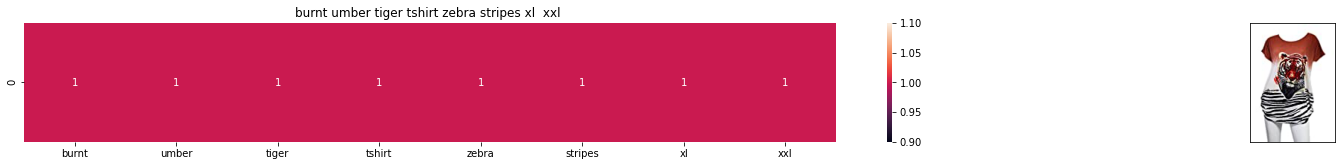

ASIN:  B00JXQB5FQ
Brand:  Si Row
Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image:  0.0


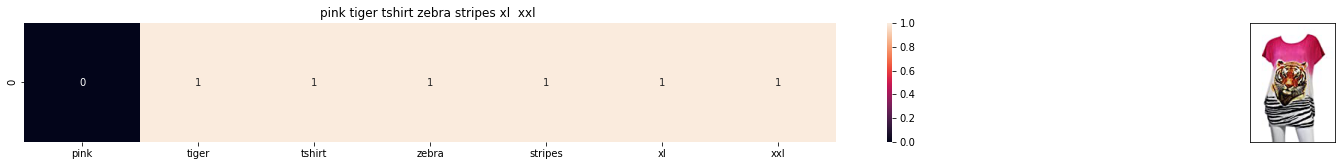

ASIN:  B00JXQASS6
Brand:  Si Row
Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image:  1.7320508075688772


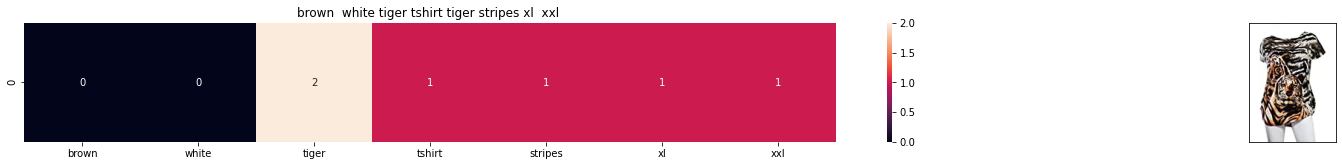

ASIN:  B00JXQCWTO
Brand:  Si Row
Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean similarity with the query image:  2.449489742783178


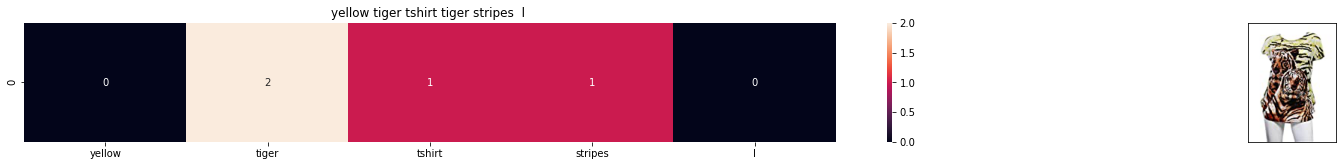

ASIN:  B00JXQCUIC
Brand:  Si Row
Title:  yellow tiger tshirt tiger stripes  l 
Euclidean similarity with the query image:  2.6457513110645907


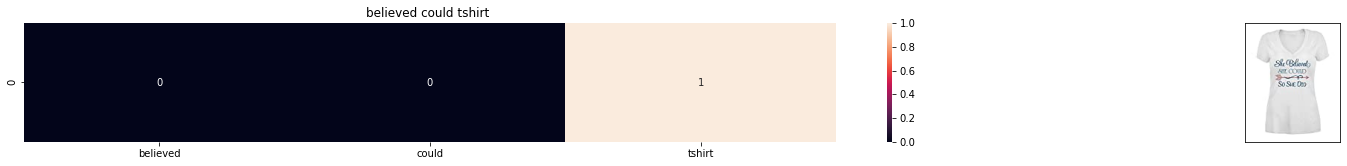

ASIN:  B07568NZX4
Brand:  Rustic Grace
Title:  believed could tshirt 
Euclidean similarity with the query image:  3.0


In [9]:
def bag_of_words_model(doc_id, num_results):
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    pairwise_dist = pairwise_distances(title_features, title_features[doc_id])
    
    # indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    #pdists will store the smallest distances
    pdists = np.sort(pairwise_dist.flatten())[0:num_results]
    
    #data frame indices of the 9 smallest distaces
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')        
        
        print('ASIN: ', data['asin'].loc[df_indices[i]])
        print('Brand: ', data['brand'].loc[df_indices[i]])
        print('Title: ', data['title'].loc[df_indices[i]])
        print('Euclidean similarity with the query image: ', pdists[i])
        print('='*60)
        
bag_of_words_model(12566, 5)
        

# TF-IDF based product similarity

In [10]:
tfidf_title_vectorizer = TfidfVectorizer(min_df=0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

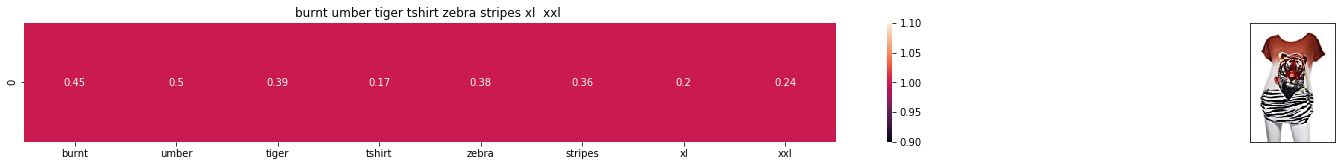

ASIN : B00JXQB5FQ
BRAND : Si Row
Eucliden distance from the given image : 0.0


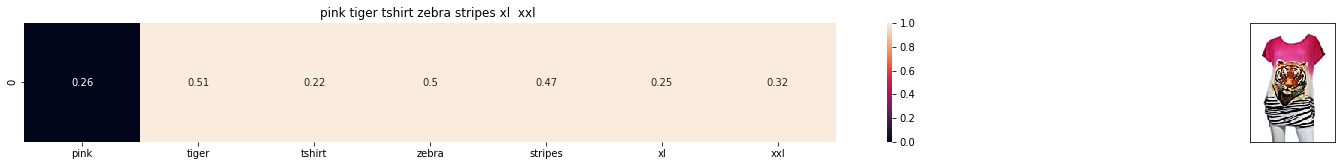

ASIN : B00JXQASS6
BRAND : Si Row
Eucliden distance from the given image : 0.7536331912451363


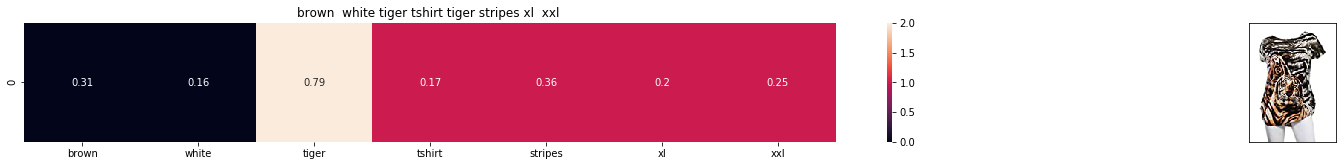

ASIN : B00JXQCWTO
BRAND : Si Row
Eucliden distance from the given image : 0.9357643943769647


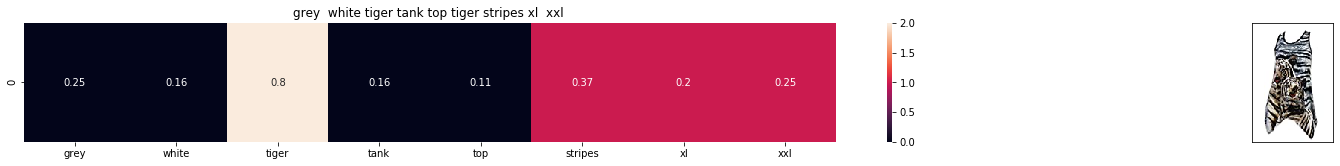

ASIN : B00JXQAFZ2
BRAND : Si Row
Eucliden distance from the given image : 0.9586153524200749


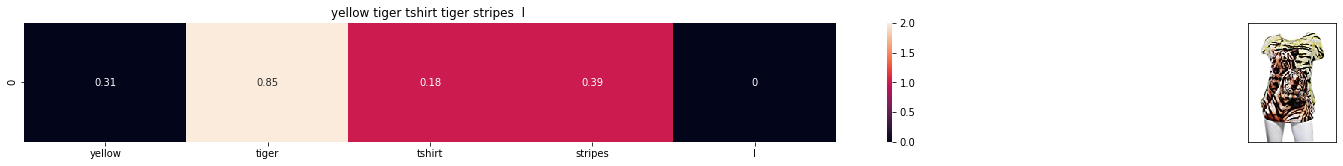

ASIN : B00JXQCUIC
BRAND : Si Row
Eucliden distance from the given image : 1.000074961446881


In [59]:
def tfidf_model(doc_id, num_results):
    
    pairwise_dist = pairwise_distances(tfidf_title_features, tfidf_title_features[doc_id])
    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    pdists = np.sort(pairwise_dist.flatten())[0:num_results]
    
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
        
tfidf_model(12566, 5)

# IDF based product similarity

In [11]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

In [61]:
def n_containing(word):
    #returns the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    return math.log(data.shape[0]/n_containing(word))

In [62]:
idf_title_features = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    idf_val = idf(i)
    
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        # we replace the count values of word i in document j with  idf_value of word i 
        idf_title_features[j, idf_title_vectorizer.vocabulary_[i]] = idf_val

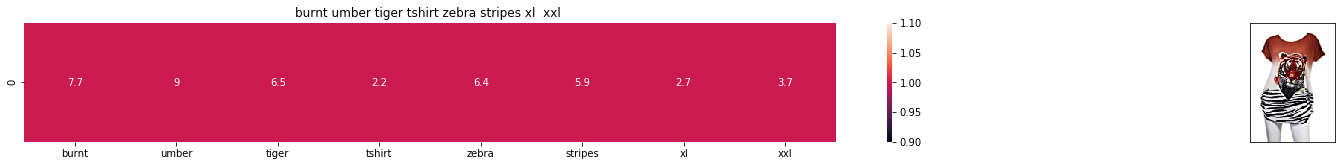

ASIN:  B00JXQB5FQ
Brand : Si Row
euclidean distance from the given image : 0.0


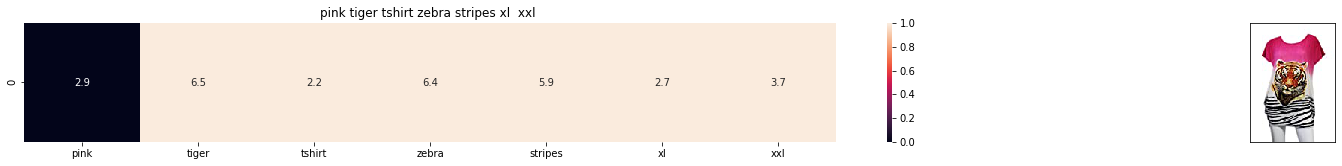

ASIN:  B00JXQASS6
Brand : Si Row
euclidean distance from the given image : 12.20507131122177


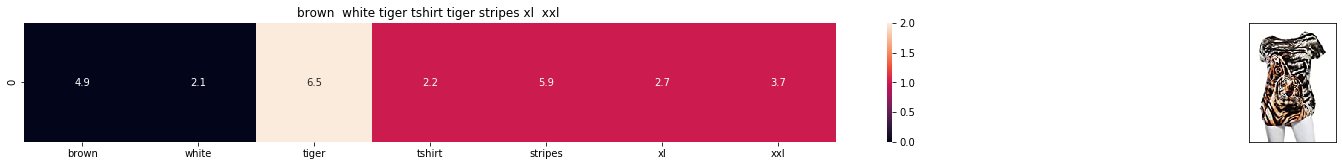

ASIN:  B00JXQCWTO
Brand : Si Row
euclidean distance from the given image : 14.468362685603465


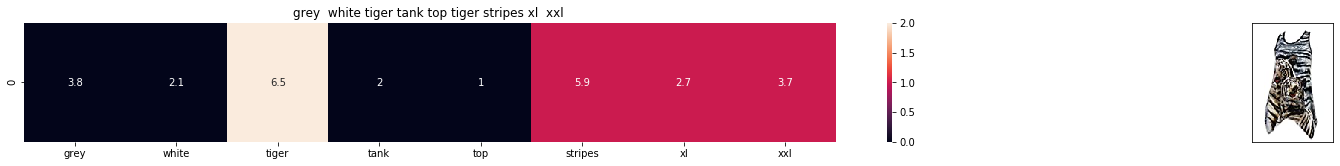

ASIN:  B00JXQAFZ2
Brand : Si Row
euclidean distance from the given image : 14.486832924778964


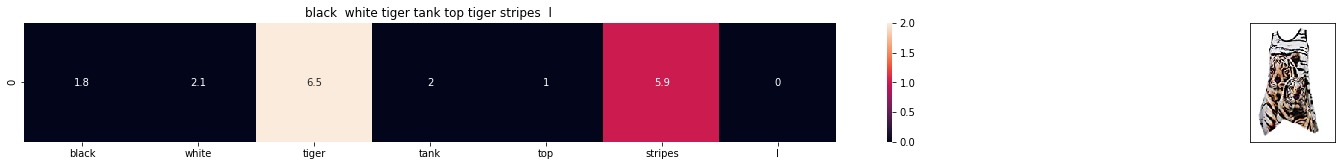

ASIN:  B00JXQAO94
Brand : Si Row
euclidean distance from the given image : 14.833392966672909


In [64]:
def idf_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(idf_title_features, idf_title_features[doc_id])
    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    pdists = np.sort(pairwise_dist.flatten())[0:num_results]
    
    df_indices = list(data.index[indices])
    
    for i in range (0, len(indices)):
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN: ', data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)
        
idf_model(12566, 5)

# Text Semantics based product similarity

In [12]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [13]:
with open('C:/Users/YASH/Similar Products/word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [14]:
# Utility functions

def get_word_vec(sentence, doc_id, m_name):
    
    # if  m_name == 'avg', we will append the model[i], w2v representation of word i
    # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
                
        else:
            vec.append(np.zeros(shape=(300, )))
    
    # we will return a numpy array of shape (#number of words in title * 300 ),  300 = len(w2v_model[word])
    return np.array(vec)


def get_distance(vec1, vec2):
    
    final_dist = []
    for i in vec1:
        dist = []
        for j in vec2:
            dist.append(np.linalg.norm(i-j))     # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
        final_dist.append(np.array(dist))
        
    return np.array(final_dist)


def heat_map(sentence1, sentence2, url, doc_id1, doc_id2, model):
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    s2_vec = get_word_vec(sentence2, doc_id2, model)
    
    s1_s2_dist = get_distance(s1_vec, s2_vec)
    
    
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[2,1])
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.round(s1_s2_dist, 4), annot=True)
    ax.set_xticklabels(sentence2.split())
    ax.set_yticklabels(sentence1.split())
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [16]:
vocab = model.keys()

# this function will add the vectors of each word and returns the avg vector of given sentence

def build_avg_vec(sentence, num_features, doc_id, m_name):
    
    featureVec = np.zeros((num_features,), dtype='float32')
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        
        if word in vocab:
            if m_name == 'weighted' and word in idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
        
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    
    return featureVec

In [17]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id, 'weighted'))
    doc_id += 1
    
w2v_title_weight = np.array(w2v_title_weight)

# Weighted similarity using brand and color

In [18]:
data['brand'].fillna(value="Not given", inplace=True)

brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [19]:
def heat_map_w2v_brand(sentence1, sentence2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    s2_vec = get_word_vec(sentence2, doc_id2, model)
    
    s1_s2_dist = get_distance(s1_vec, s2_vec)
    
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'], [.5, '#f2e5ff'],[1, '#f2e5d1']]
    
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    
    plotly.offline.iplot(table, filename='simple_table')
    
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    ax1 = plt.subplot(gs[:, :-5])
    ax1 = sns.heatmap(np.round(s1_s2_dist, 6), annot=True)
    ax1.set_xticklabels(sentence2.split())
    ax1.set_yticklabels(sentence1.split())
    ax1.set_title(sentence2)
    
    ax2 = plt.subplot(gs[:, 10:16])
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    display_img(url, ax2, fig)
    
    plt.show()

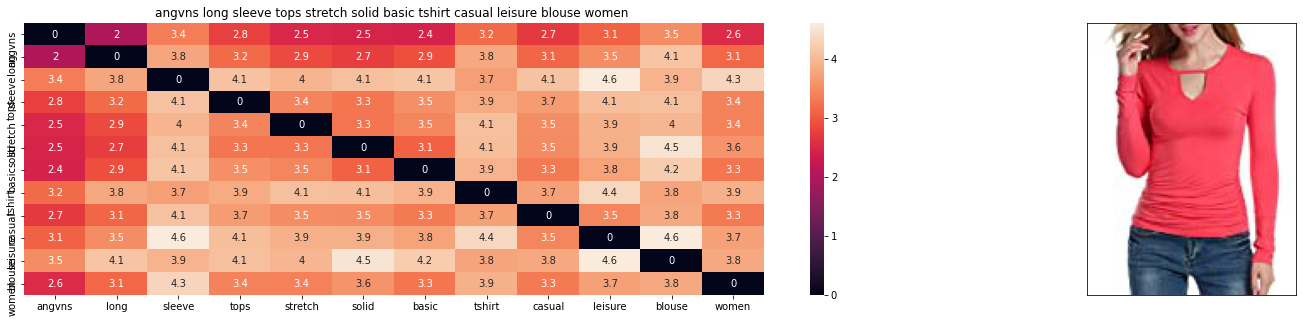

ASIN : B01LXOHUO8
Brand : ANGVNS
euclidean distance from input : 0.0


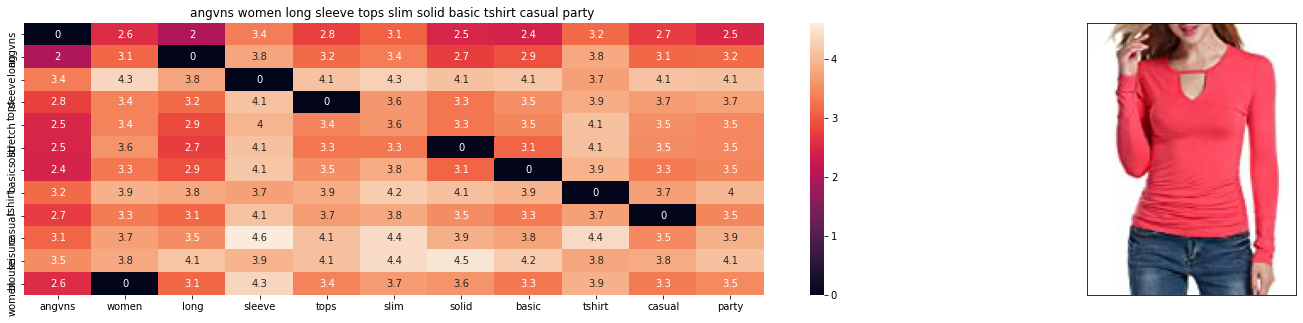

ASIN : B01LYZCBOM
Brand : ANGVNS
euclidean distance from input : 0.27505037784576414


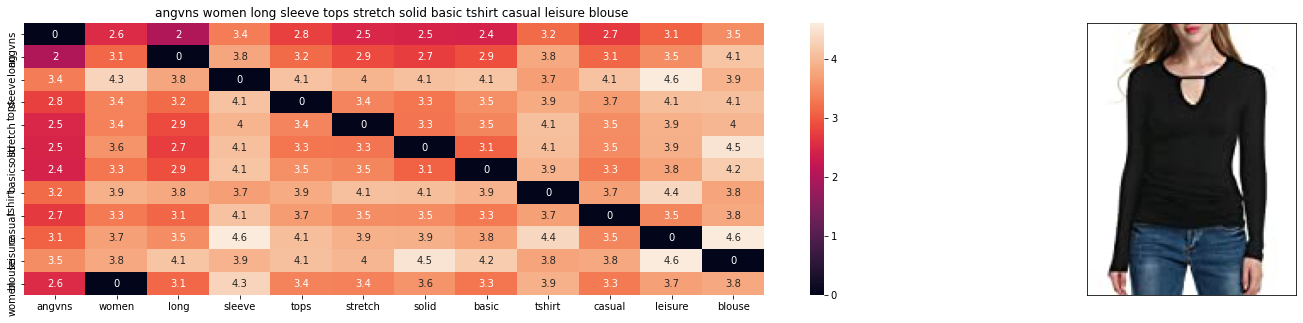

ASIN : B01M0A8I0S
Brand : ANGVNS
euclidean distance from input : 0.7071067811865476


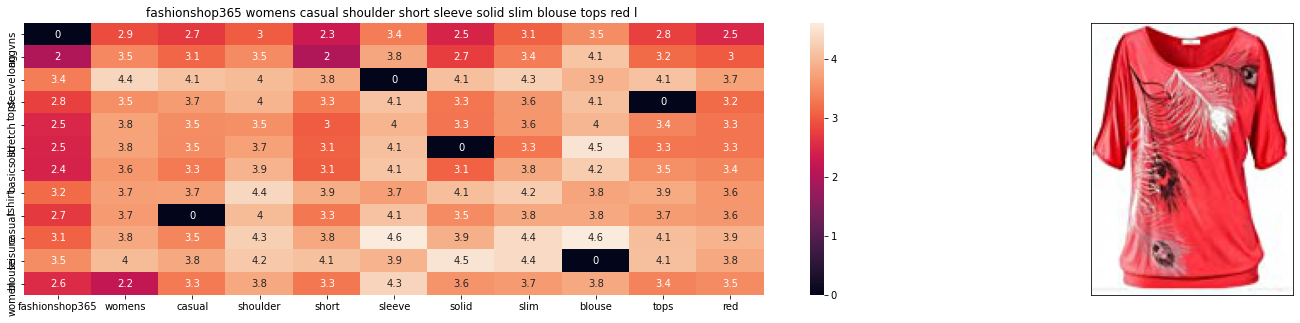

ASIN : B01HTR6KMI
Brand : FashionShop365
euclidean distance from input : 1.0162369253058103


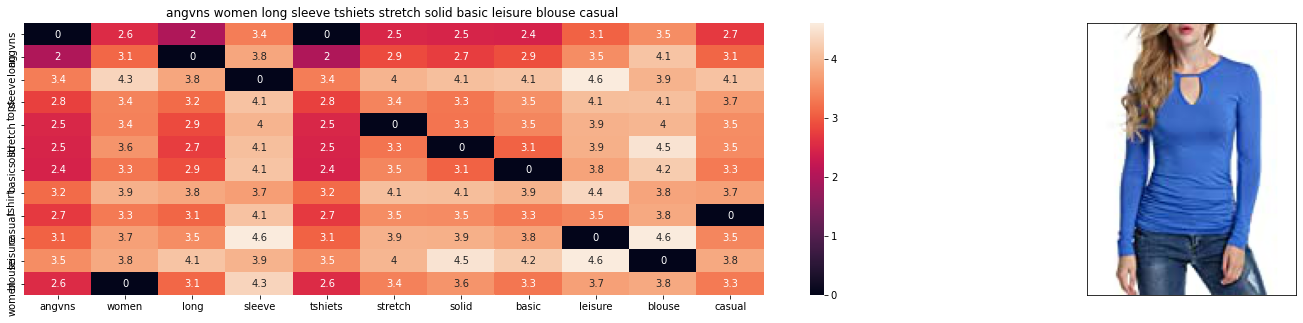

ASIN : B01M1V33VA
Brand : ANGVNS
euclidean distance from input : 1.0443375385271754


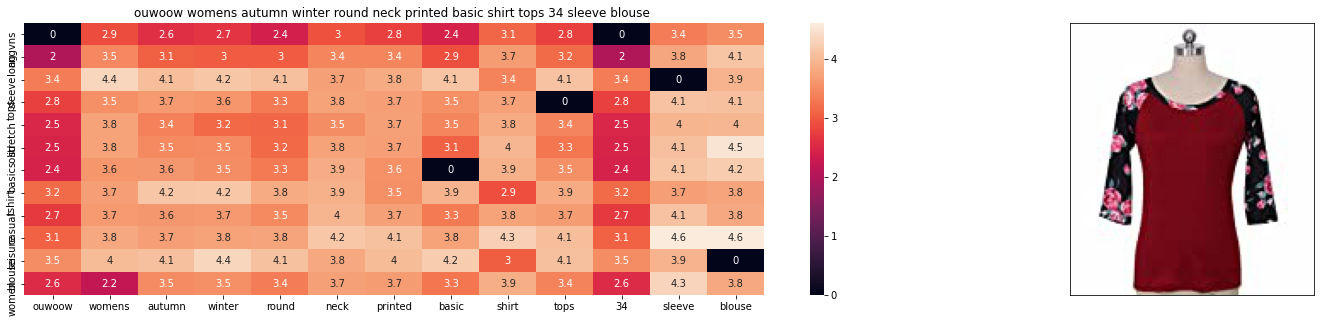

ASIN : B01MDRB8AB
Brand : ouwoow
euclidean distance from input : 1.0853734971899656


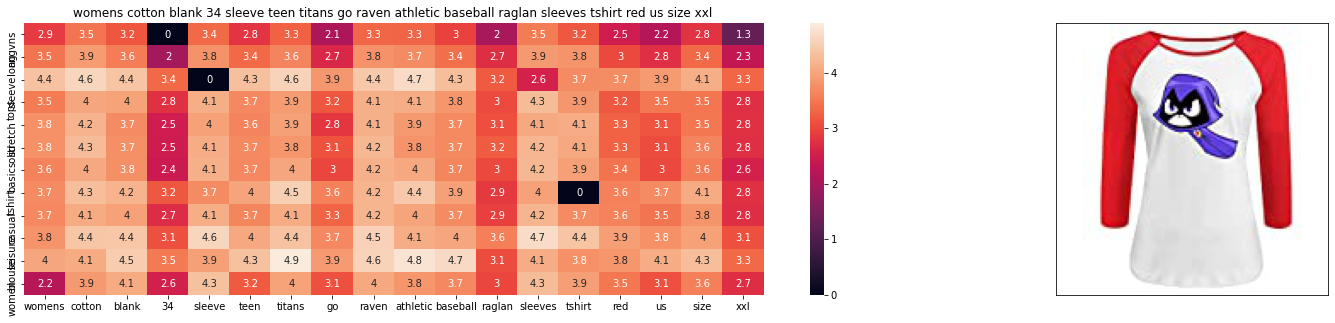

ASIN : B01M4IJ7IR
Brand : SDFJY
euclidean distance from input : 1.1355336191076901


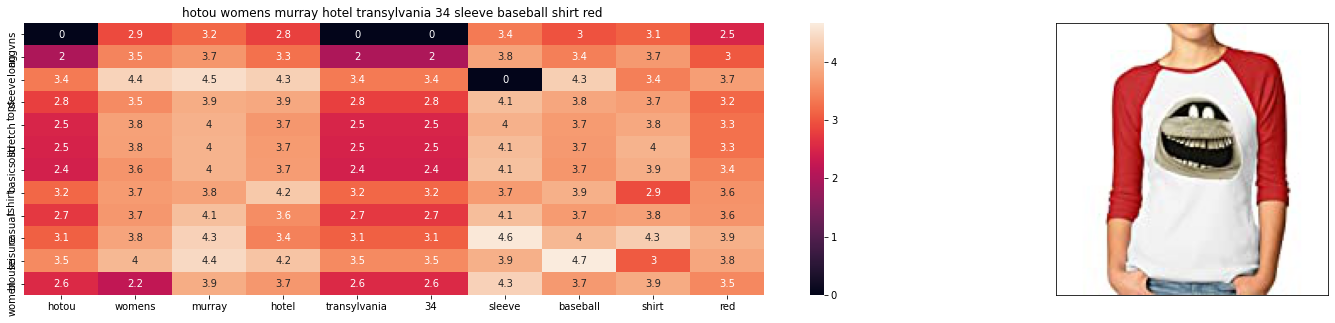

ASIN : B01GE73QY4
Brand : HOTOU
euclidean distance from input : 1.1526486398596432


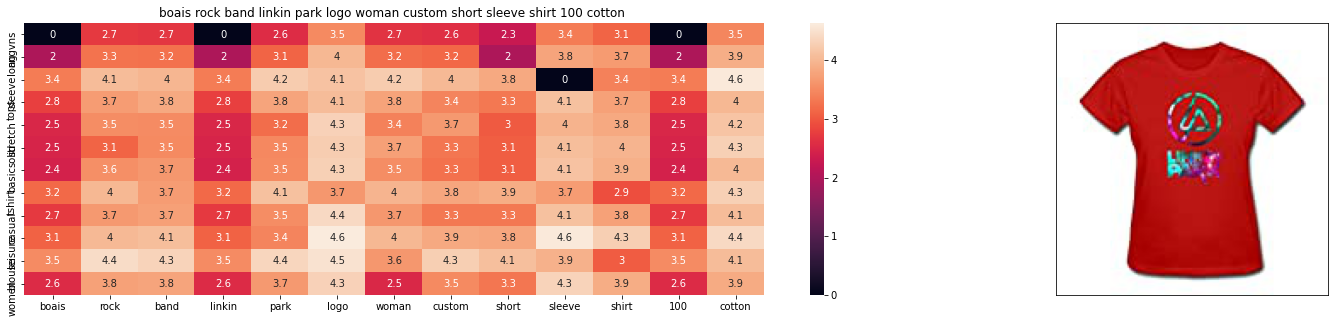

ASIN : B016BG4UMK
Brand : BOAIS
euclidean distance from input : 1.1626188280005123


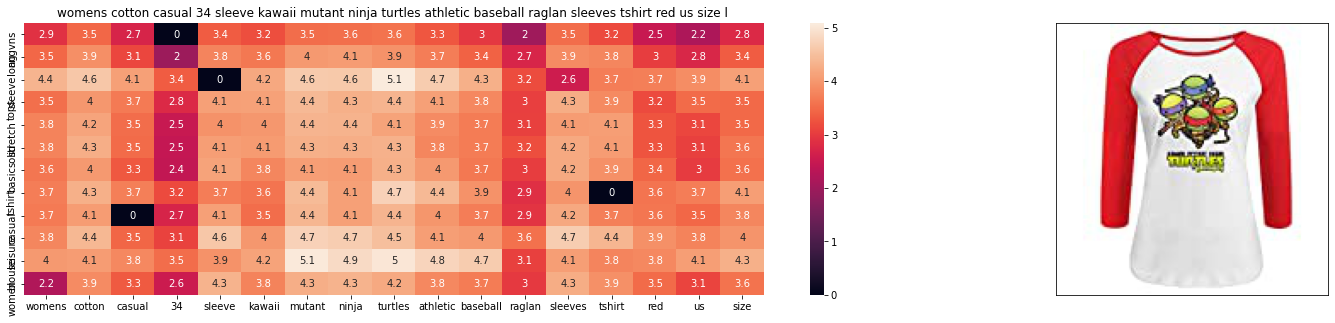

ASIN : B01M63J4CA
Brand : SDFJY
euclidean distance from input : 1.1691198350805905


In [20]:
def idf_w2v_brand(doc_id, w1, w2, num_results):
    
    # w1: weight for  w2v features
    # w2: weight for brand and color features
    
    idf_w2v_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist = (w1 * idf_w2v_dist + w2 * ex_feat_dist)/float(w1 + w2)
    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)
        
idf_w2v_brand(1250, 5, 5, 10)

In [23]:
bottleneck_features_train = np.load('C:/Users/YASH/Similar Products/features.npy')

## Combining Images and Text similarity to make a similar product recommender system

In [24]:
def idf_w2v_brand_with_image(doc_id, w1, w2, w3, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
#     ------------------------------------------
    image_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist + w3 * image_dist)/float(w1 + w2 + w3)
#     ------------------------------------------

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

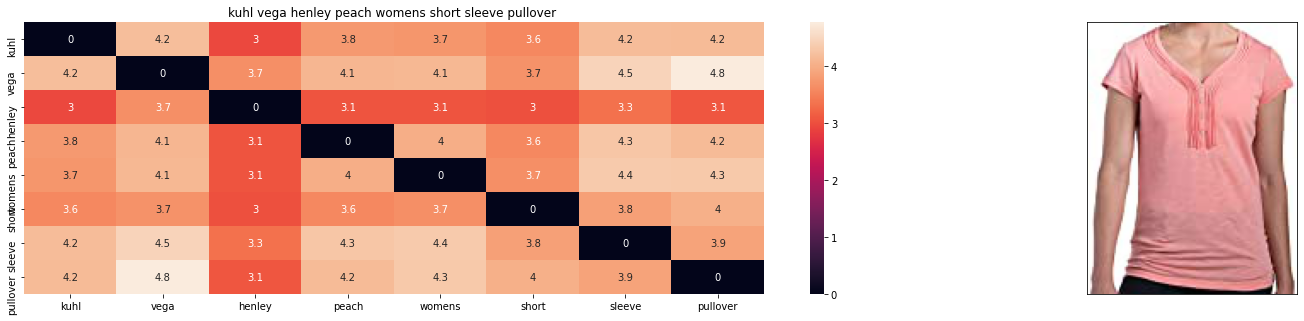

ASIN : B00ZUYRT00
Brand : Kuhl
euclidean distance from input : 4.095948481170291e-06


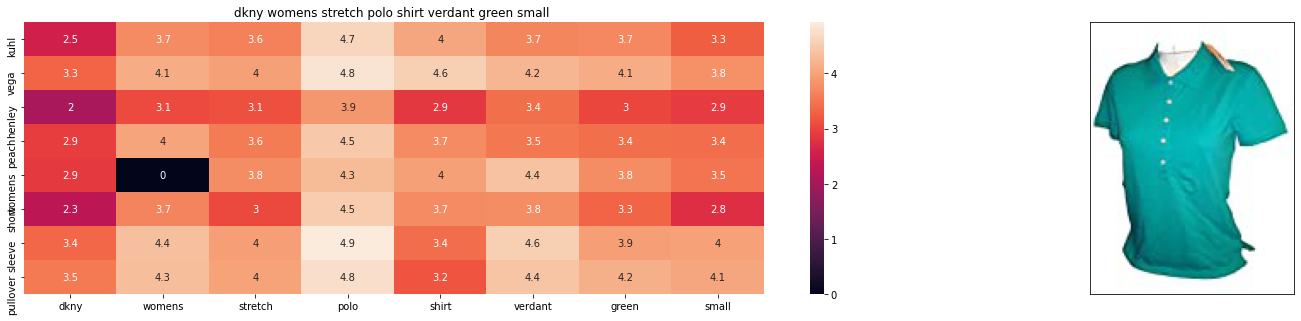

ASIN : B00BMTBHSM
Brand : DKNY
euclidean distance from input : 21.89927459686701


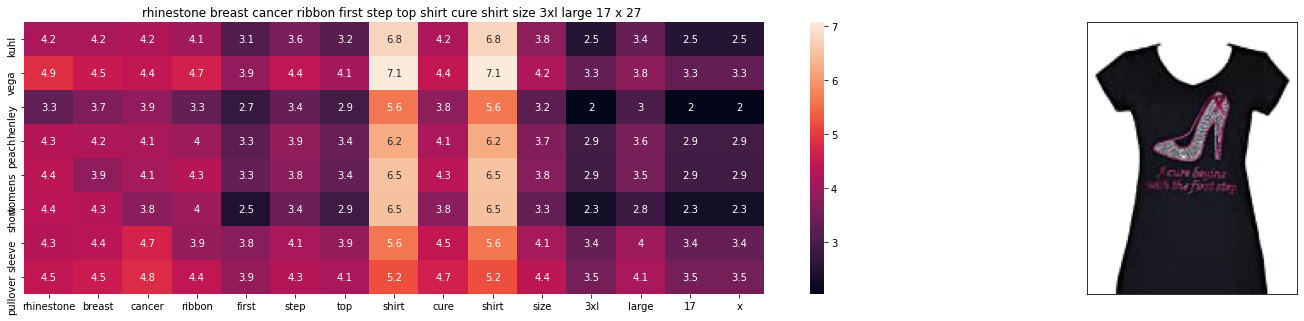

ASIN : B010VZKIVO
Brand : other
euclidean distance from input : 22.465539564351914


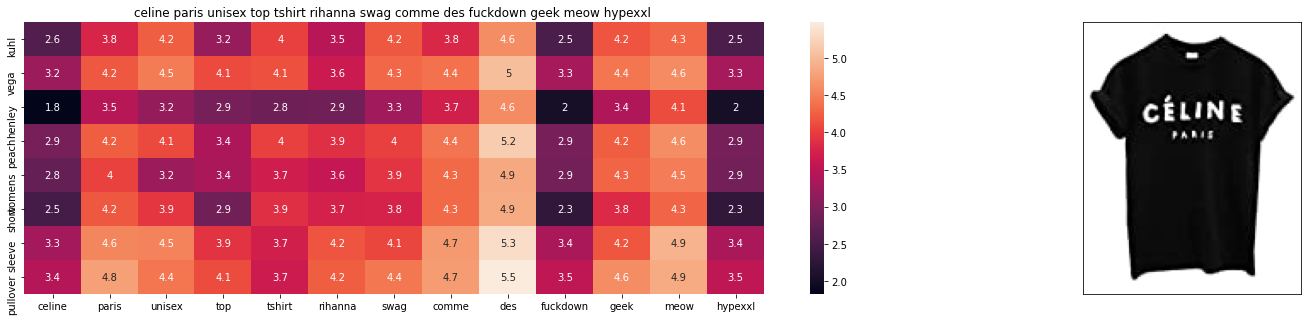

ASIN : B01FKKWMLE
Brand : Storesaver
euclidean distance from input : 22.503246390301843


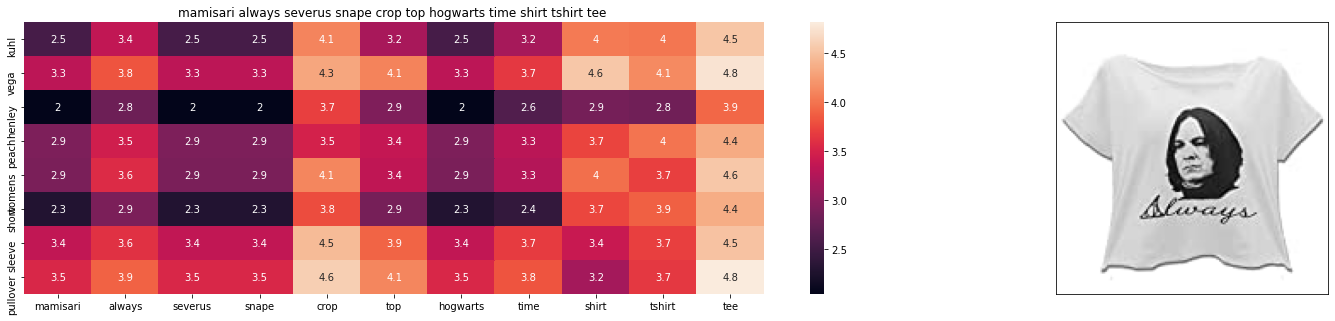

ASIN : B01LZPC561
Brand : mamisari
euclidean distance from input : 22.662805466784445


In [28]:
idf_w2v_brand_with_image(1996,20,5,30,5)

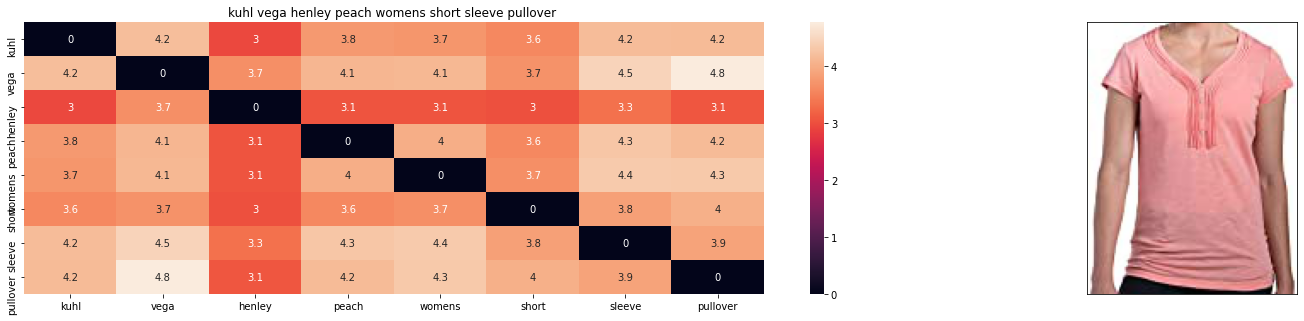

ASIN : B00ZUYRT00
Brand : Kuhl
euclidean distance from input : 1.8773096599034034e-06


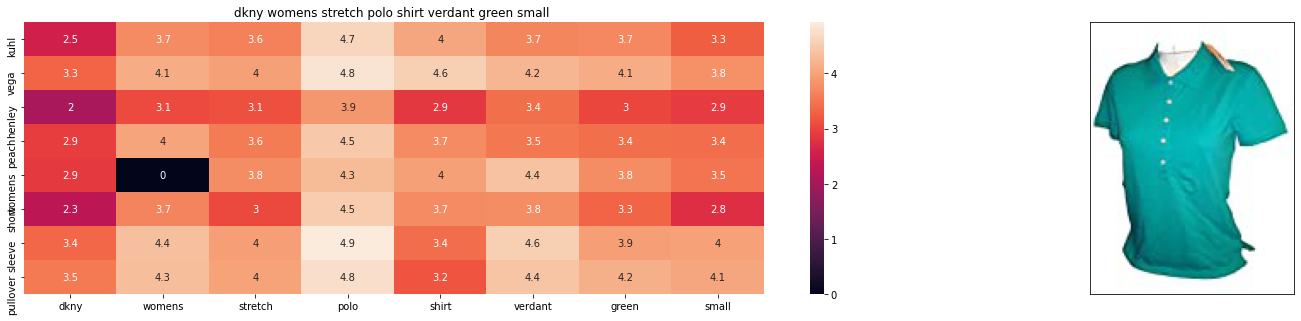

ASIN : B00BMTBHSM
Brand : DKNY
euclidean distance from input : 11.41457066329039


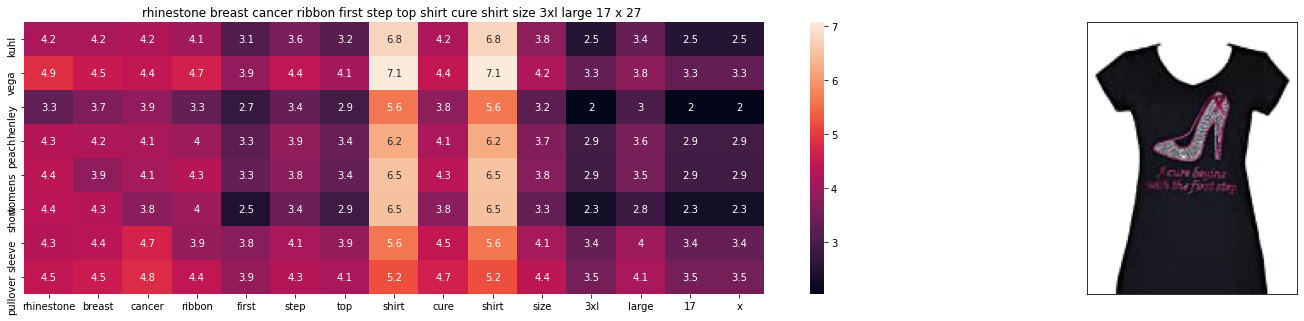

ASIN : B010VZKIVO
Brand : other
euclidean distance from input : 11.676536104994186


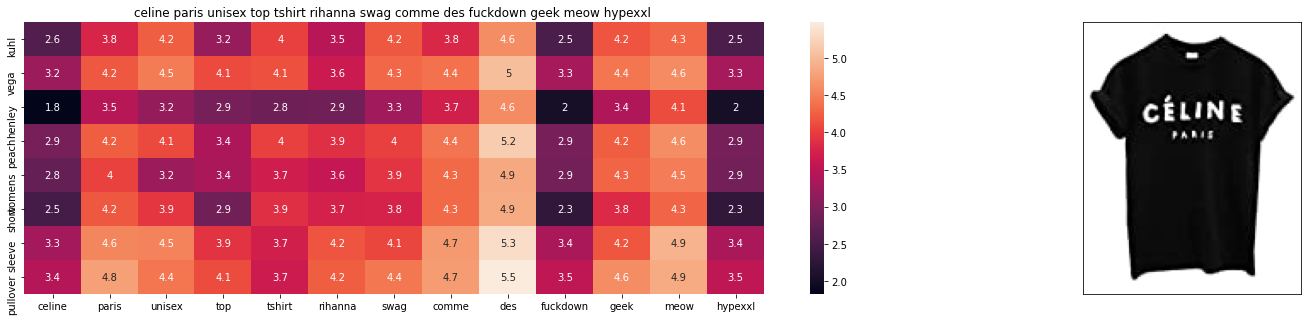

ASIN : B01FKKWMLE
Brand : Storesaver
euclidean distance from input : 11.687118218260178


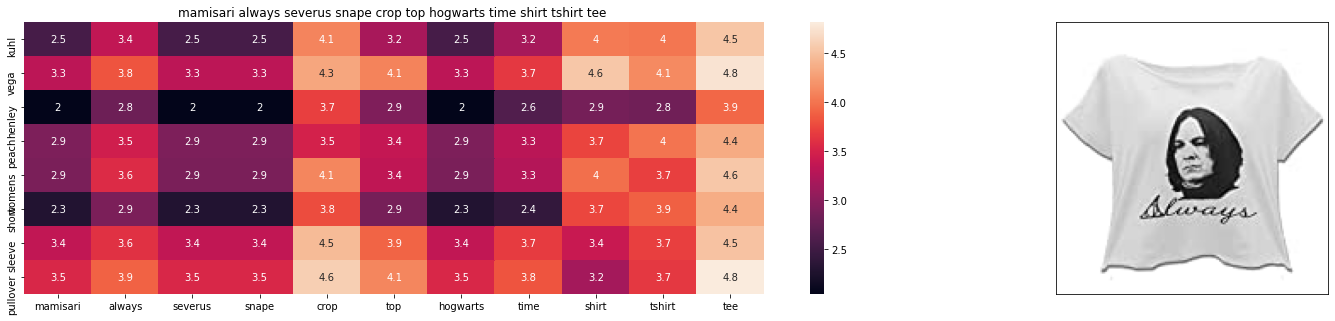

ASIN : B01LZPC561
Brand : mamisari
euclidean distance from input : 11.767798254804976


In [27]:
idf_w2v_brand_with_image(1996,10,50,20,5)

#### We can give different weightage to differnt features to obtain product similarity more focussed on a particular feature